In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

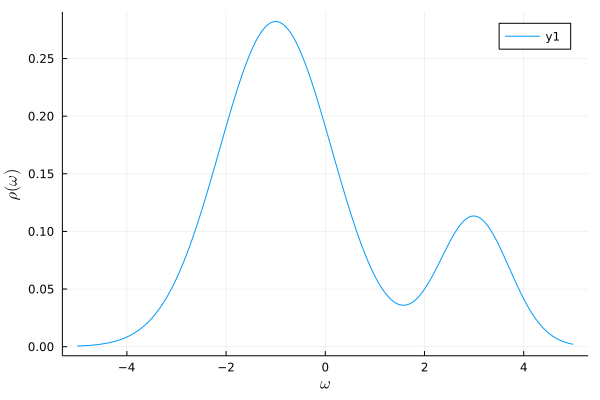

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 10
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* big.(rhol)
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

22

In [8]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.999999999999999042775863072864799724194519749389085306440861895192288064156249393802010194616483430058787647055360686549156311894575035073361069516438517634

In [9]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [10]:
for i in 1:hnw
    test_smpl[i]= im*IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [11]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 17
N_imp 17


In [52]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.854102e-03     7.641149e-03
 * time: 0.03333711624145508
     1     1.086594e-03     3.922548e-03
 * time: 2.291459083557129
     2     8.760529e-04     5.953359e-03
 * time: 2.848267078399658
     3     4.684002e-04     1.126276e-03
 * time: 3.246504068374634
     4     4.329293e-04     6.935267e-05
 * time: 3.6756110191345215
     5     4.327095e-04     7.522331e-06
 * time: 4.105844020843506
     6     4.327080e-04     9.750625e-07
 * time: 4.3894431591033936
     7     4.327079e-04     6.594754e-08
 * time: 4.690603971481323
     8     4.327079e-04     3.771050e-09
 * time: 5.319185972213745
max_theta=0.175019067043355133289347762597831278487310887679342253474333351265680464059833799903504991526926115708138507883823206282039942698676910289548564111690351215
hardy optimization was success.
 70.984940 seconds (121.35 M allocations: 6.905 GiB, 5.64% gc time, 93.98% compilation time)


In [53]:
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     4.327079e-04     3.771050e-09
 * time: 0.0009980201721191406
max_theta=0.175019067043355133289347762597831278487310887679342253474333351265680464059833799903504991526926115708138507883823206282039942698676910289548564111690351215
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.327079e-04     3.483088e-03
 * time: 0.0002651214599609375
     1     3.411412e-04     2.284666e-03
 * time: 0.7468400001525879
     2     2.600365e-04     1.277972e-03
 * time: 1.4883379936218262
     3     2.538532e-04     1.076369e-03
 * time: 2.1432011127471924
     4     1.805142e-04     4.009374e-04
 * time: 2.994050979614258
     5     1.798424e-04     4.025252e-04
 * time: 3.541728973388672
     6     1.623496e-04     8.060983e-04
 * time: 4.402390003204346
     7     1.248305e-04     1.128750e-04
 * time: 4.989957094192505
     8     1.237348e-04     3.102620e-05
 * time: 5.551423072814941
     9     1.23724

     9     5.770070e-06     4.665730e-05
 * time: 9.442625045776367
    10     5.625923e-06     4.698940e-05
 * time: 10.757014989852905
    11     5.210764e-06     3.744871e-05
 * time: 11.616816997528076
    12     5.194351e-06     3.876689e-05
 * time: 12.443479061126709
    13     5.173235e-06     3.437048e-05
 * time: 13.48533296585083
    14     4.823431e-06     4.287116e-05
 * time: 14.547515869140625
    15     4.703936e-06     2.166556e-05
 * time: 15.48931884765625
    16     4.700123e-06     2.041931e-05
 * time: 16.39657187461853
    17     4.692689e-06     2.405517e-05
 * time: 17.5289089679718
    18     4.550609e-06     2.728180e-05
 * time: 18.587479829788208
    19     4.474684e-06     1.204762e-05
 * time: 19.38810396194458
    20     4.457919e-06     5.894028e-06
 * time: 20.224920988082886
    21     4.457323e-06     7.090378e-06
 * time: 20.755306005477905
    22     4.456947e-06     7.055978e-06
 * time: 21.55402183532715
    23     4.448009e-06     9.737622e-06
 

     0     4.022426e-06     2.565800e-04
 * time: 0.00032901763916015625
     1     3.923705e-06     1.818412e-04
 * time: 0.9597229957580566
     2     3.826136e-06     9.444729e-05
 * time: 1.8465909957885742
     3     3.724644e-06     7.349102e-05
 * time: 3.033507823944092
     4     3.614850e-06     4.919200e-05
 * time: 4.198951959609985
     5     3.501540e-06     3.967857e-05
 * time: 5.765807867050171
     6     3.492048e-06     4.035075e-05
 * time: 6.636576890945435
     7     3.374845e-06     3.033838e-05
 * time: 8.119650840759277
     8     3.342851e-06     5.182585e-05
 * time: 9.580636978149414
     9     3.253612e-06     1.988537e-05
 * time: 10.549969911575317
    10     3.214949e-06     9.299538e-05
 * time: 12.048154830932617
    11     3.119057e-06     1.637876e-05
 * time: 12.946277856826782
    12     3.117727e-06     1.664323e-05
 * time: 13.845801830291748
    13     2.974716e-06     4.413962e-05
 * time: 15.617326021194458
    14     2.857007e-06     2.204725

   121     2.340556e-06     2.179890e-08
 * time: 93.74766802787781
   122     2.340556e-06     2.383426e-08
 * time: 94.32583093643188
   123     2.340556e-06     2.383451e-08
 * time: 94.92515182495117
   124     2.340556e-06     2.593725e-08
 * time: 95.51609396934509
   125     2.340556e-06     2.602922e-08
 * time: 96.12193703651428
   126     2.340556e-06     2.820305e-08
 * time: 96.70738291740417
   127     2.340556e-06     2.837918e-08
 * time: 97.30131793022156
   128     2.340556e-06     3.065227e-08
 * time: 97.89907884597778
   129     2.340556e-06     3.091198e-08
 * time: 98.54867792129517
   130     2.340556e-06     3.330883e-08
 * time: 99.07778000831604
   131     2.340556e-06     3.366245e-08
 * time: 99.6478259563446
   132     2.340556e-06     3.618793e-08
 * time: 100.20665287971497
   133     2.340556e-06     3.665013e-08
 * time: 100.79923796653748
   134     2.340556e-06     3.930180e-08
 * time: 101.38108396530151
   135     2.340556e-06     3.988471e-08
 * ti

    50     1.955192e-06     9.036666e-06
 * time: 42.397326946258545
    51     1.953376e-06     1.145839e-05
 * time: 43.09660005569458
    52     1.951790e-06     7.609491e-06
 * time: 43.96919393539429
    53     1.950309e-06     1.103055e-05
 * time: 44.65152311325073
    54     1.949052e-06     6.185705e-06
 * time: 45.404622077941895
    55     1.947885e-06     1.053574e-05
 * time: 46.02975010871887
    56     1.946924e-06     4.807579e-06
 * time: 46.96880006790161
    57     1.946022e-06     9.949795e-06
 * time: 47.66879892349243
    58     1.945308e-06     4.267773e-06
 * time: 48.36645293235779
    59     1.944599e-06     9.183743e-06
 * time: 49.66675090789795
    60     1.944065e-06     4.554625e-06
 * time: 50.517173051834106
    61     1.943427e-06     7.816427e-06
 * time: 52.02241492271423
    62     1.942963e-06     3.869826e-06
 * time: 53.2497980594635
    63     1.942117e-06     3.706079e-06
 * time: 54.24651598930359
    64     1.941203e-06     6.611464e-06
 * ti

   171     1.916149e-06     5.281635e-06
 * time: 138.53561210632324
   172     1.915731e-06     4.340074e-06
 * time: 139.59634399414062
   173     1.915378e-06     5.140441e-06
 * time: 140.23955297470093
   174     1.914906e-06     4.106323e-06
 * time: 141.27550101280212
   175     1.914509e-06     4.940801e-06
 * time: 141.97461891174316
   176     1.913968e-06     3.794415e-06
 * time: 142.93088793754578
   177     1.913517e-06     4.671812e-06
 * time: 143.75856399536133
   178     1.912891e-06     3.389972e-06
 * time: 144.96284699440002
   179     1.912373e-06     4.340285e-06
 * time: 145.60086703300476
   180     1.911641e-06     3.200216e-06
 * time: 146.71122908592224
   181     1.911043e-06     4.659130e-06
 * time: 147.61299204826355
   182     1.910182e-06     3.212001e-06
 * time: 148.90886688232422
   183     1.909492e-06     4.969969e-06
 * time: 149.5576479434967
   184     1.908473e-06     3.316981e-06
 * time: 150.63372206687927
   185     1.907680e-06     5.25884

   291     1.877887e-06     1.273137e-06
 * time: 230.7664020061493
   292     1.877859e-06     2.314571e-06
 * time: 231.44808197021484
   293     1.877830e-06     1.266123e-06
 * time: 232.04757809638977
   294     1.877803e-06     2.304943e-06
 * time: 232.69569897651672
   295     1.877774e-06     1.258635e-06
 * time: 233.36228609085083
   296     1.877746e-06     2.295733e-06
 * time: 234.0283648967743
   297     1.877718e-06     1.250421e-06
 * time: 234.68833303451538
   298     1.877690e-06     2.286600e-06
 * time: 235.35926795005798
   299     1.877662e-06     1.241280e-06
 * time: 235.99807596206665
   300     1.877635e-06     2.277244e-06
 * time: 236.77453207969666
   301     1.877606e-06     1.231176e-06
 * time: 237.3817310333252
   302     1.877579e-06     2.267495e-06
 * time: 238.00758409500122
   303     1.877551e-06     1.220280e-06
 * time: 238.61227703094482
   304     1.877524e-06     2.257317e-06
 * time: 239.28822493553162
   305     1.877495e-06     1.208901e

   411     1.875335e-06     1.010957e-06
 * time: 312.92378091812134
   412     1.875306e-06     2.315217e-06
 * time: 313.5352439880371
   413     1.875265e-06     1.048472e-06
 * time: 314.49344992637634
   414     1.875232e-06     2.357078e-06
 * time: 315.1252670288086
   415     1.875185e-06     1.089801e-06
 * time: 316.0693700313568
   416     1.875147e-06     2.401422e-06
 * time: 316.6751220226288
   417     1.875092e-06     1.134398e-06
 * time: 317.61214303970337
   418     1.875049e-06     2.447384e-06
 * time: 318.2064230442047
   419     1.874986e-06     1.181235e-06
 * time: 319.18238711357117
   420     1.874935e-06     2.493717e-06
 * time: 319.8507950305939
   421     1.874862e-06     1.228756e-06
 * time: 320.76999592781067
   422     1.874803e-06     2.538861e-06
 * time: 321.362890958786
   423     1.874719e-06     1.274903e-06
 * time: 322.2967550754547
   424     1.874651e-06     2.580802e-06
 * time: 322.9207088947296
   425     1.874555e-06     1.317075e-06
 * 

   531     1.865766e-06     1.983818e-06
 * time: 395.6908218860626
   532     1.865747e-06     1.154092e-06
 * time: 396.22311997413635
   533     1.865729e-06     1.973430e-06
 * time: 396.7509889602661
   534     1.865712e-06     1.164369e-06
 * time: 397.27831506729126
   535     1.865695e-06     1.963973e-06
 * time: 397.8153429031372
   536     1.865678e-06     1.174529e-06
 * time: 398.35237407684326
   537     1.865662e-06     1.955314e-06
 * time: 398.921737909317
   538     1.865646e-06     1.184208e-06
 * time: 399.474093914032
   539     1.865630e-06     1.947169e-06
 * time: 399.9908781051636
   540     1.865614e-06     1.193155e-06
 * time: 400.50796604156494
   541     1.865599e-06     1.939140e-06
 * time: 401.1181139945984
   542     1.865584e-06     1.201240e-06
 * time: 401.77150988578796
   543     1.865569e-06     1.930812e-06
 * time: 402.4652659893036
   544     1.865554e-06     1.208426e-06
 * time: 403.20175790786743
   545     1.865540e-06     1.921875e-06
 * 

   651     1.864468e-06     1.829003e-06
 * time: 460.6519019603729
   652     1.864458e-06     1.361380e-06
 * time: 461.1741280555725
   653     1.864449e-06     1.828956e-06
 * time: 461.6547110080719
   654     1.864439e-06     1.362759e-06
 * time: 462.16266894340515
   655     1.864429e-06     1.829028e-06
 * time: 462.68763303756714
   656     1.864419e-06     1.364057e-06
 * time: 463.21381306648254
   657     1.864410e-06     1.829279e-06
 * time: 463.6959569454193
   658     1.864400e-06     1.365314e-06
 * time: 464.22984409332275
   659     1.864390e-06     1.829749e-06
 * time: 464.8299720287323
   660     1.864380e-06     1.366577e-06
 * time: 465.4664249420166
   661     1.864371e-06     1.830455e-06
 * time: 466.0289969444275
   662     1.864361e-06     1.367896e-06
 * time: 466.54391407966614
   663     1.864351e-06     1.831393e-06
 * time: 467.03456687927246
   664     1.864341e-06     1.369314e-06
 * time: 467.5606310367584
   665     1.864331e-06     1.832546e-06
 

   772     1.863106e-06     1.496953e-06
 * time: 521.2319369316101
   773     1.863093e-06     1.920116e-06
 * time: 521.7379870414734
   774     1.863080e-06     1.499123e-06
 * time: 522.1938099861145
   775     1.863067e-06     1.921091e-06
 * time: 522.6907830238342
   776     1.863054e-06     1.501241e-06
 * time: 523.1932508945465
   777     1.863041e-06     1.922075e-06
 * time: 523.6825609207153
   778     1.863027e-06     1.503319e-06
 * time: 524.1462650299072
   779     1.863014e-06     1.923088e-06
 * time: 524.6532320976257
   780     1.863001e-06     1.505368e-06
 * time: 525.1372790336609
   781     1.862988e-06     1.924149e-06
 * time: 525.6077699661255
   782     1.862974e-06     1.507404e-06
 * time: 526.2121860980988
   783     1.862961e-06     1.925272e-06
 * time: 526.8191809654236
   784     1.862948e-06     1.509438e-06
 * time: 527.3941740989685
   785     1.862934e-06     1.926465e-06
 * time: 527.8828239440918
   786     1.862921e-06     1.511486e-06
 * time

   893     1.861345e-06     1.998986e-06
 * time: 581.2709128856659
   894     1.861329e-06     1.641496e-06
 * time: 581.6920750141144
   895     1.861313e-06     2.000180e-06
 * time: 582.1452670097351
   896     1.861298e-06     1.643979e-06
 * time: 582.5924160480499
   897     1.861282e-06     2.001316e-06
 * time: 583.0315110683441
   898     1.861266e-06     1.646438e-06
 * time: 583.5022230148315
   899     1.861250e-06     2.002386e-06
 * time: 583.916729927063
   900     1.861235e-06     1.648866e-06
 * time: 584.4006390571594
   901     1.861219e-06     2.003385e-06
 * time: 584.8823010921478
   902     1.861203e-06     1.651259e-06
 * time: 585.336837053299
   903     1.861187e-06     2.004312e-06
 * time: 585.790755033493
   904     1.861171e-06     1.653611e-06
 * time: 586.1993238925934
   905     1.861156e-06     2.005164e-06
 * time: 586.7167799472809
   906     1.861140e-06     1.655921e-06
 * time: 587.1564149856567
   907     1.861124e-06     2.005944e-06
 * time: 5

In [14]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.


LoadError: MethodError: no method matching RealDomainData(::Int64, ::Float64, ::Float64, ::BigFloat; T=BigFloat)
[0mClosest candidates are:
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m; T, small_omega, mesh) at ~/work/Nevanlinna_f/src/data.jl:55
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Array{Complex{T}, 1}[39m, [91m::Array{Complex{T}, 1}[39m) where T<:Real at ~/work/Nevanlinna_f/src/data.jl:47[91m got unsupported keyword argument "T"[39m

In [15]:
plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi)
#plot!(omegas, rho.(omegas))

LoadError: UndefVarError: raw_reals not defined

In [16]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

LoadError: UndefVarError: sol not defined

In [17]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.


LoadError: MethodError: no method matching RealDomainData(::Int64, ::Float64, ::Float64; T=BigFloat)
[0mClosest candidates are:
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m; T, small_omega, mesh) at ~/work/Nevanlinna_f/src/data.jl:55
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Array{Complex{T}, 1}[39m, [91m::Array{Complex{T}, 1}[39m) where T<:Real at ~/work/Nevanlinna_f/src/data.jl:47[91m got unsupported keyword argument "T"[39m

In [18]:
using FastGaussQuadrature
using OMEinsum
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end
#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(((collect(1:200).-100)/1000000)*2*pi*im/beta, -omega_max, omega_max, 1000000)

;

In [51]:
using FastGaussQuadrature
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_sum_omega(xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    sum_omega = 0.0
    for i in 1:deg
        sum_omega += (quad_rule[2] .* rho.(quad_rule[1]))[i]
    end

    return sum_omega
end
sum_o = calc_sum_omega(-omega_max, omega_max, 1000)

0.9999999999999988

In [19]:
exact_g[11]

0.4137278708783536 + 0.5996660156993593im

In [20]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [21]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [22]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [23]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [24]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [25]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#